# Setting Up

In [135]:
#!pip install sqlalchemy
#!pip install pyodbc
!pip install scipy
from sqlalchemy import create_engine, Table, inspect
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        # For Windows authentication
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        assert user, 'You must define a username'
        assert password, 'You must define a password'
        # For SQL Server authentication
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    print(eng)
    return create_engine(eng)

engine = new_engine('mssql', 'LAPTOP-KUGOV3A2', 'AdventureWorks2022')
engine = create_engine("mssql://LAPTOP-KUGOV3A2/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server")
connection = engine.connect()
inspector = inspect(engine)
schemas = inspector.get_schema_names()
print(schemas)

mssql://LAPTOP-KUGOV3A2/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server
['db_accessadmin', 'db_backupoperator', 'db_datareader', 'db_datawriter', 'db_ddladmin', 'db_denydatareader', 'db_denydatawriter', 'db_owner', 'db_securityadmin', 'dbo', 'guest', 'HumanResources', 'INFORMATION_SCHEMA', 'Person', 'Production', 'Purchasing', 'Sales', 'sys']


# Coding

Flera olika sätt görs för att analysera Produktion-delen, men främst fokuseras det på Standard Kostnad, Försäljningspris, produktionID, antalet dagar per produktion, kategori. Produktions-delen verkar problematisk gällande tid per produktion och vilken enhet Kostnad samt Pris kan vara. Även vid försök att koppla Produktion till Sales.Currency misslyckas då inte alla Produkter följs med.

In [203]:
cte_sql_first_part = cte_sql = """
WITH ProductCTE AS (
    SELECT 
		P.ProductID,
        PC.Name AS ProductName,
        P.ProductNumber,
        P.MakeFlag,
        P.FinishedGoodsFlag,
        P.Color,
        P.SafetyStockLevel,
        P.ReorderPoint,
        P.StandardCost,
        P.ListPrice,
        (P.ListPrice - P.StandardCost) AS Profit_Per_ProductID,
        SUM(I.Quantity) AS Total_Quantity_Per_ProductID,
        COUNT(I.LocationID) AS Locations_Per_ProductID,
        P.Size,
        P.SizeUnitMeasureCode,
        P.WeightUnitMeasureCode,
        P.Weight,
        P.DaysToManufacture,
        P.ProductLine,
        P.Class,
        P.Style,
        P.ProductSubcategoryID,
        P.ProductModelID,
        P.SellStartDate,
        P.SellEndDate,
        P.DiscontinuedDate,
        P.rowguid,
        P.ModifiedDate
    FROM 
        [AdventureWorks2022].[Production].[Product] P
    INNER JOIN 
        [AdventureWorks2022].[Production].[ProductInventory] I ON P.ProductID = I.ProductID
    INNER JOIN
        [AdventureWorks2022].[Production].[ProductSubcategory] PS ON P.ProductSubcategoryID = PS.ProductSubcategoryID
    INNER JOIN
        [AdventureWorks2022].[Production].[ProductCategory] PC ON PS.ProductCategoryID = PC.ProductCategoryID
    GROUP BY 
        P.ProductID, PC.Name, P.ProductNumber, P.MakeFlag, P.FinishedGoodsFlag,
        P.Color, P.SafetyStockLevel, P.ReorderPoint, P.StandardCost, P.ListPrice,
        P.Size, P.SizeUnitMeasureCode, P.WeightUnitMeasureCode, P.Weight,
        P.DaysToManufacture, P.ProductLine, P.Class, P.Style,
        P.ProductSubcategoryID, P.ProductModelID, P.SellStartDate,
        P.SellEndDate, P.DiscontinuedDate, P.rowguid, P.ModifiedDate
    HAVING 
        P.StandardCost <> 0 AND SUM(I.Quantity) IS NOT NULL
)
"""



In [204]:
cte_sql_second_part_A = """

SELECT 
        ProductName,
        Locations_Per_ProductID
FROM ProductCTE
GROUP BY Locations_Per_ProductID, ProductName
ORDER BY Locations_Per_ProductID DESC
"""

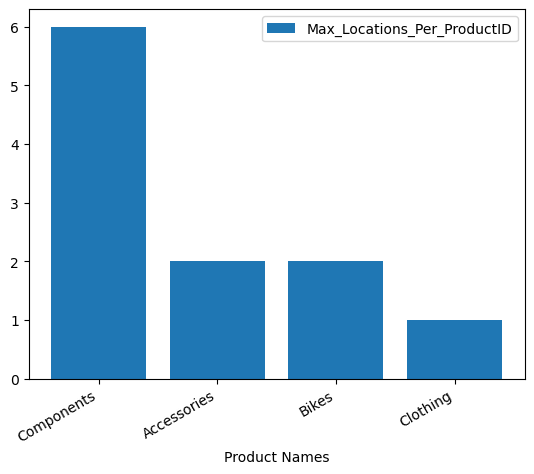

In [129]:
result = pd.read_sql(cte_sql_first_part + cte_sql_second_part_A, engine)
plt.bar(result['ProductName'], result['Locations_Per_ProductID'], label='Max_Locations_Per_ProductID')
plt.xticks(rotation=30, ha="right")
plt.legend(loc='upper right')
plt.xlabel('Product Names')
plt.show()
#result.plot(x="ProductName", y="Locations_Per_ProductID", kind="bar")#using panda

In [130]:
cte_sql_second_part_B = """

SELECT 
        ProductID,
        ProductName,
        Profit_Per_ProductID,
        Total_Quantity_Per_ProductID,
        DaysToManufacture,
        ProductLine
FROM ProductCTE
ORDER BY ProductID
"""
result = pd.read_sql(cte_sql_first_part + cte_sql_second_part_B, engine)
print(result.head(25))

first_column = result.iloc[:, 0]
column_length = len(first_column)
print("Real size of table above: ", column_length)

    ProductID  ProductName  Profit_Per_ProductID  \
0         707  Accessories               21.9037   
1         708  Accessories               21.9037   
2         709     Clothing                6.1037   
3         710     Clothing                6.1037   
4         711  Accessories               21.9037   
5         712     Clothing                2.0677   
6         713     Clothing               11.4977   
7         714     Clothing               11.4977   
8         715     Clothing               11.4977   
9         716     Clothing               11.4977   
10        747   Components              610.5590   
11        748   Components              617.2998   
12        749        Bikes             1406.9758   
13        750        Bikes             1406.9758   
14        751        Bikes             1406.9758   
15        752        Bikes             1406.9758   
16        753        Bikes             1406.9758   
17        754        Bikes              573.2817   
18        75

In [167]:
#cte_sql_second_part_C = """
#
#SELECT 
#    SUM(ProductID) AS Total_ProductIDs, 
#    ProductName, 
#    AVG(StandardCost) AS Avg_StandardCost, 
#    AVG(ListPrice) AS Avg_ListPrice, 
#    AVG(ListPrice - StandardCost) AS Avg_Profit_Per_ProductName, 
#    AVG(CAST(Total_Quantity_Per_ProductID AS DECIMAL)) AS Avg_Total_Quantity_Per_ProductName
#FROM ProductCTE
#WHERE ProductName = 'Clothing'
#GROUP BY ProductName
#"""
#cte_sql_second_part_C = """
#
#SELECT 
#    ProductID, 
#    ((ListPrice) - (StandardCost)) AS Profit_Per_Clothing, 
#    Total_Quantity_Per_ProductID
#FROM ProductCTE
#WHERE ProductName = 'Clothing'
#"""
cte_sql_second_part_C = """

SELECT 
    ((ListPrice) - (StandardCost)) AS Profit_Per_ProductID 
FROM ProductCTE
WHERE ProductName = 'Clothing'
"""
result = pd.read_sql(cte_sql_first_part + cte_sql_second_part_C, engine)
print(result.head(25))

first_column = result.iloc[:, 0]
column_length = len(first_column)
print("Real size of table above: ", column_length)

    Profit_Per_ProductID
0                 6.1037
1                 6.1037
2                 2.0677
3                11.4977
4                11.4977
5                11.4977
6                11.4977
7                35.2441
8                35.2441
9                35.2441
10               35.2441
11               44.0566
12               44.0566
13               44.0566
14               52.8691
15               52.8691
16               52.8691
17               15.3307
18               15.3307
19               15.3307
20               22.3191
21               22.3191
22               22.3191
23               39.7510
24               39.7510
Real size of table above:  35


In [205]:
#cte_sql_second_part_COther = """
#
#SELECT 
#    ProductID, 
#    ((ListPrice) - (StandardCost)) AS Profit_Per_ProductID, 
#    Total_Quantity_Per_ProductID
#FROM ProductCTE
#"""
cte_sql_second_part_COther = """

SELECT
    ((ListPrice) - (StandardCost)) AS Profit_Per_ProductID
FROM ProductCTE
"""
result = pd.read_sql(cte_sql_first_part + cte_sql_second_part_COther, engine)
print(result.head(10))
first_column = result.iloc[:, 0]
column_length = len(first_column)
print("Real size of table above: ", column_length)


   Profit_Per_ProductID
0               21.9037
1               21.9037
2                6.1037
3                6.1037
4               21.9037
5                2.0677
6               11.4977
7               11.4977
8               11.4977
9               11.4977
Real size of table above:  223


Mean of Group 1: [26.18826]
Mean of Group 2: [310.25800673]
STD of Group 1: [16.4134699]
STD of Group 2: [402.13042273]
Sample size of Group 1: 35
Sample size of Group 2: 223
95% Confidence Interval for the Difference: [-337.38032658], [-230.75916688]


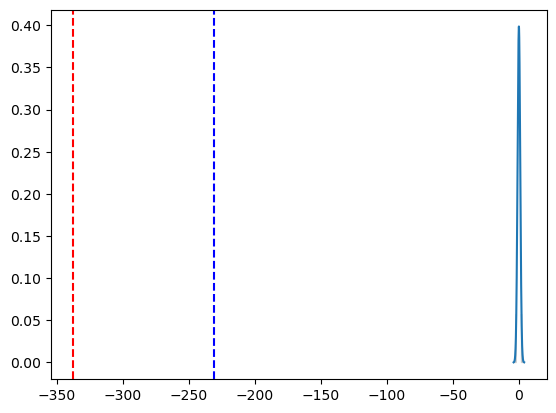

In [189]:
# Sample data for two groups
group1 = pd.read_sql(cte_sql_first_part + cte_sql_second_part_C, engine).to_numpy()
#group1 = group1.to_numpy()
group2 = pd.read_sql(cte_sql_first_part + cte_sql_second_part_COther, engine).to_numpy()

# Calculate means
#mean_group1 = np.mean(group1)
mean_group1 = np.mean(group1, axis=0)
#mean_group2 = np.mean(group2)
mean_group2 = np.mean(group2, axis=0)

# Calculate standard deviations
#std_group1 = np.std(group1, ddof=1)  # ddof=1 for sample standard deviation
std_group1 = np.std(group1, axis=0, ddof=1)
#std_group2 = np.std(group2, ddof=1)
std_group2 = np.std(group2, axis=0, ddof=1)

# Calculate standard errors
se_group1 = std_group1 / np.sqrt(len(group1))
se_group2 = std_group2 / np.sqrt(len(group2))

#sample size
n_group1 = len(group1)
n_group2 = len(group2)

# Degrees of freedom
df = len(group1) + len(group2) - 2

# Calculate the 95% confidence interval for the difference between means
confidence_interval = stats.t.interval(0.95, 
                                       df,
                                       mean_group1 - mean_group2,
                                       np.sqrt(se_group1**2 + se_group2**2))

print(f"Mean of Group 1: {mean_group1}")
print(f"Mean of Group 2: {mean_group2}")
print(f"STD of Group 1: {std_group1}")
print(f"STD of Group 2: {std_group2}")
print(f"Sample size of Group 1: {n_group1}")
print(f"Sample size of Group 2: {n_group2}")
lower_bound, upper_bound = confidence_interval
print(f"95% Confidence Interval for the Difference: {lower_bound}, {upper_bound}")

# Critical value for a two-tailed 95% confidence interval
t_critical = stats.t.ppf(0.975, df)

# Plotting the t-distribution
x = np.linspace(-4, 4, 1000)  # adjust the range based on your data
y = stats.t.pdf(x, df)

plt.plot(x, y, label='t-distribution')

# Highlight the area between the critical values
plt.fill_between(x, 0, y, where=(x < -t_critical) | (x > t_critical), color='gray', alpha=0.3, label='Critical Region')

# Add vertical lines for the confidence interval bounds
plt.axvline(lower_bound, color='red', linestyle='--', label='Lower Bound')
plt.axvline(upper_bound, color='blue', linestyle='--', label='Upper Bound')

In [190]:
cte_sql_second_part_D = """

SELECT 
    SUM(ProductID) AS Total_ProductIDs, 
    ProductName,
    ProductLine,
    SUM(CAST(Total_Quantity_Per_ProductID AS DECIMAL)) AS Total_Quantity_Per_Combinations_Of_ProductName_AND_ProductLine,
    AVG(CAST(Total_Quantity_Per_ProductID AS DECIMAL)) AS Avg_Total_Quantity_Per_Combinations_Of_ProductName_AND_ProductLine
FROM ProductCTE
GROUP BY ProductName, ProductLine
ORDER BY ProductName
"""
result = pd.read_sql(cte_sql_first_part + cte_sql_second_part_D, engine)
print(result.head(20))


first_column = result.iloc[:, 0]
column_length = len(first_column)
print("Real size of table above: ", column_length)

    Total_ProductIDs  ProductName ProductLine  \
0               7181  Accessories          M    
1               7131  Accessories          R    
2               8189  Accessories          S    
3               2699  Accessories          T    
4              27842        Bikes          M    
5              34913        Bikes          R    
6              21207        Bikes          T    
7               6609     Clothing          M    
8               1749     Clothing          R    
9              20790     Clothing          S    
10             15308   Components        None   
11             18020   Components          M    
12             12837   Components          R    
13              8141   Components          T    

    Total_Quantity_Per_Combinations_Of_ProductName_AND_ProductLine  \
0                                              3170.0                
1                                              2958.0                
2                                              1944.0 

In [127]:
cte_sql_second_part_E = """

SELECT 
    SUM(ProductID) AS Total_ProductIDs,
    ProductLine,
    ProductName,
    DaysToManufacture
FROM ProductCTE
GROUP BY ProductLine, DaysToManufacture, ProductName
ORDER BY ProductLine
"""
result = pd.read_sql(cte_sql_first_part + cte_sql_second_part_E, engine)
print(result.head(20))


first_column = result.iloc[:, 0]
column_length = len(first_column)
print("Real size of table above: ", column_length)

    Total_ProductIDs ProductLine  ProductName  DaysToManufacture
0              15308        None   Components                  1
1               7181          M   Accessories                  0
2               6609          M      Clothing                  0
3              12882          M    Components                  1
4               5138          M    Components                  2
5              27842          M         Bikes                  4
6               7131          R   Accessories                  0
7               1749          R      Clothing                  0
8              12015          R    Components                  1
9                822          R    Components                  2
10             34913          R         Bikes                  4
11              8189          S   Accessories                  0
12             20790          S      Clothing                  0
13              2699          T   Accessories                  0
14              8141     

In [196]:
#cte_sql_second_part_F = """
#
#SELECT 
#    SUM(ProductID) AS Total_ProductIDs, 
#    ProductName,
#    DaysToManufacture,
#    SUM(CAST(Total_Quantity_Per_ProductID AS DECIMAL)) AS Total_Quantity_Per_Combinations_Of_ProductName_AND_DaysToManufacture,
#    AVG(CAST(Total_Quantity_Per_ProductID AS DECIMAL)) AS Avg_Total_Quantity_Per_Combinations_Of_ProductName_AND_DaysToManufacture
#FROM ProductCTE
#GROUP BY ProductName, DaysToManufacture
#ORDER BY DaysToManufacture
#"""
cte_sql_second_part_F = """

SELECT 
    SUM(ProductID) AS Total_ProductIDs, 
    ProductName,
    DaysToManufacture
FROM ProductCTE
GROUP BY ProductName, DaysToManufacture
ORDER BY DaysToManufacture
"""
result = pd.read_sql(cte_sql_first_part + cte_sql_second_part_F, engine)
print(result.head(5))


first_column = result.iloc[:, 0]
column_length = len(first_column)
print("Real size of table above: ", column_length)

   Total_ProductIDs  ProductName  DaysToManufacture
0             25200  Accessories                  0
1             29148     Clothing                  0
2             48346   Components                  1
3              5960   Components                  2
4             83962        Bikes                  4
Real size of table above:  5


In [211]:
cte_sql_first_part = cte_sql = """
  WITH ProductSalesCTE AS (
    SELECT 
        P.ProductID,
        PC.Name AS Product_Name,
        P.StandardCost,
        P.ListPrice,
        (P.ListPrice - P.StandardCost) AS Profit_Per_Unit,
		CR.FromCurrencyCode,
		CR.ToCurrencyCode,
		I.LocationID
    FROM 
        [AdventureWorks2022].[Production].[Product] P
    INNER JOIN 
        [AdventureWorks2022].[Production].[ProductInventory] I ON P.ProductID = I.ProductID
    INNER JOIN 
        [AdventureWorks2022].[Production].[ProductSubcategory] PS ON P.ProductSubCategoryID = PS.ProductSubCategoryID
    INNER JOIN 
        [AdventureWorks2022].[Production].[ProductCategory] PC ON PS.ProductCategoryID = PC.ProductCategoryID
	INNER JOIN 
        [AdventureWorks2022].[Purchasing].[PurchaseOrderDetail] POV ON P.ProductID = POV.ProductID
	INNER JOIN 
        [AdventureWorks2022].[Purchasing].[PurchaseOrderHeader] POH ON POV.PurchaseOrderID = POH.PurchaseOrderID
	INNER JOIN 
        [AdventureWorks2022].[Purchasing].[ShipMethod] SM ON POH.ShipMethodID = SM.ShipMethodID
	INNER JOIN 
        [AdventureWorks2022].[Sales].[SalesOrderHeader] SOH ON SM.ShipMethodID = SOH.ShipMethodID
	INNER JOIN 
        [AdventureWorks2022].[Sales].[CurrencyRate] CR ON SOH.CurrencyRateID = CR.CurrencyRateID
    GROUP BY 
        P.ProductID, PC.Name, P.StandardCost, P.ListPrice,
		CR.FromCurrencyCode, CR.ToCurrencyCode, I.LocationID
	HAVING 
        P.StandardCost <> 0
)
"""
#cte_sql_second_part_G = """
#
#SELECT 
#    ProductID,
#    Product_Name, 
#    COUNT(DISTINCT CASE WHEN FromCurrencyCode IS NOT NULL THEN FromCurrencyCode END) AS FromCurrencyCode_Count, 
#    COUNT(DISTINCT CASE WHEN ToCurrencyCode IS NOT NULL THEN ToCurrencyCode END) AS ToCurrencyCode_Count, 
#    COUNT(DISTINCT LocationID) AS Locations
#FROM 
#    ProductSalesCTE
#GROUP BY 
#    ProductID,
#    Product_Name
#
#ORDER BY 
#    ProductID;
#"""
cte_sql_second_part_G = """

SELECT 
    ProductID,
    Product_Name, 
    COUNT(DISTINCT CASE WHEN FromCurrencyCode IS NOT NULL THEN FromCurrencyCode END) AS FromCurrencyCode_Count, 
    COUNT(DISTINCT CASE WHEN ToCurrencyCode IS NOT NULL THEN ToCurrencyCode END) AS ToCurrencyCode_Count 
FROM 
    ProductSalesCTE
GROUP BY 
    ProductID,
    Product_Name

ORDER BY 
    ProductID;
"""
result = pd.read_sql(cte_sql_first_part + cte_sql_second_part_G, engine)
print(result.head(10))


first_column = result.iloc[:, 0]
column_length = len(first_column)
print("Real size of table above: ", column_length)


   ProductID Product_Name  FromCurrencyCode_Count  ToCurrencyCode_Count
0        907   Components                       1                     4
1        912   Components                       1                     4
2        913   Components                       1                     4
3        914   Components                       1                     4
4        915   Components                       1                     4
5        916   Components                       1                     4
6        922  Accessories                       1                     5
7        923  Accessories                       1                     5
8        928  Accessories                       1                     4
9        929  Accessories                       1                     4
Real size of table above:  23


In [209]:
cte_sql_first_part = cte_sql = """
WITH ProductSales2CTE AS (
    SELECT 
        P.ProductID,
        PC.Name AS Product_Name,
        P.StandardCost,
        P.ListPrice,
        (P.ListPrice - P.StandardCost) AS Profit_Per_Unit,
		CR.FromCurrencyCode,
		CR.ToCurrencyCode,
		I.LocationID
    FROM 
        [AdventureWorks2022].[Production].[Product] P
    INNER JOIN 
        [AdventureWorks2022].[Production].[ProductInventory] I ON P.ProductID = I.ProductID
    INNER JOIN 
        [AdventureWorks2022].[Production].[ProductSubcategory] PS ON P.ProductSubCategoryID = PS.ProductSubCategoryID
    INNER JOIN 
        [AdventureWorks2022].[Production].[ProductCategory] PC ON PS.ProductCategoryID = PC.ProductCategoryID
	INNER JOIN 
        [AdventureWorks2022].[Purchasing].[ProductVendor] PV ON P.ProductID = PV.ProductID
	INNER JOIN 
        [AdventureWorks2022].[Purchasing].[Vendor] V ON V.BusinessEntityID = PV.BusinessEntityID
	INNER JOIN 
        [AdventureWorks2022].[Purchasing].[PurchaseOrderHeader] POH ON POH.VendorID = V.BusinessEntityID
	INNER JOIN 
        [AdventureWorks2022].[Purchasing].[ShipMethod] SM ON POH.ShipMethodID = SM.ShipMethodID
	INNER JOIN 
        [AdventureWorks2022].[Sales].[SalesOrderHeader] SOH ON SM.ShipMethodID = SOH.ShipMethodID
	INNER JOIN 
        [AdventureWorks2022].[Sales].[CurrencyRate] CR ON SOH.CurrencyRateID = CR.CurrencyRateID
    GROUP BY 
        P.ProductID, PC.Name, P.StandardCost, P.ListPrice,
		CR.FromCurrencyCode, CR.ToCurrencyCode, I.LocationID
	HAVING 
        P.StandardCost <> 0
 )
"""
cte_sql_second_part_H = """

SELECT 
    ProductID,
    Product_Name, 
    COUNT(DISTINCT CASE WHEN FromCurrencyCode IS NOT NULL THEN FromCurrencyCode END) AS FromCurrencyCode_Count, 
    COUNT(DISTINCT CASE WHEN ToCurrencyCode IS NOT NULL THEN ToCurrencyCode END) AS ToCurrencyCode_Count, 
    COUNT(DISTINCT LocationID) AS Locations
FROM 
    ProductSales2CTE
GROUP BY 
    ProductID,
    Product_Name
ORDER BY 
    ProductID;
"""
result = pd.read_sql(cte_sql_first_part + cte_sql_second_part_H, engine)
print(result.head(10))


first_column = result.iloc[:, 0]
column_length = len(first_column)
print("Real size of table above: ", column_length)


   ProductID Product_Name  FromCurrencyCode_Count  ToCurrencyCode_Count  \
0        907   Components                       1                     4   
1        908   Components                       1                     4   
2        909   Components                       1                     4   
3        910   Components                       1                     4   
4        911   Components                       1                     4   
5        912   Components                       1                     4   
6        913   Components                       1                     4   
7        914   Components                       1                     4   
8        915   Components                       1                     4   
9        916   Components                       1                     4   

   Locations  
0          3  
1          3  
2          3  
3          3  
4          3  
5          3  
6          3  
7          3  
8          3  
9          3  
Real size